# Influencer-Product-Fit CALC

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
from tqdm import tqdm
import os
from bs4 import BeautifulSoup

In [10]:
# Correct file paths
post_path_1 = 'post1_with_four_adtags.xlsx'


# Load data
raw_post1 = pd.read_excel(post_path_1, engine='openpyxl')

In [11]:
# Filter rows where 'whether_is_ad' column equals 'ad'
post1 = raw_post1[raw_post1['whether_is_ad'] == 'ad'].copy()

# Display the number of filtered rows
print(f"✅ Filtered {len(post1)} rows where 'whether_is_ad' == 'ad'")

# Optionally, display the filtered dataset
post1.head()

✅ Filtered 17007 rows where 'whether_is_ad' == 'ad'


,user_name,user_id,post_id,date,media_type,likes,comments,views,caption,media_urls,sponsor_tags,whether_is_ad,ad_product_category,ad_product_name,advertising_brand
1,shanedawson,171146,3499285996154630144,2024-11-11 23:23:00,Video,57786,1285,0,Hungry for a New Conspiracy Video? I know I am...,https://scontent-sjc3-1.cdninstagram.com/o1/v/...,NaN,ad,Others,video,na
2,shanedawson,171146,3491996435582260224,2024-11-01 22:00:00,Album,186098,2012,0,5 years of the Conspiracy Collection and Serie...,https://scontent-sjc3-1.cdninstagram.com/v/t51...,NaN,ad,All_Beauty,eyeshadow palette,jeffreestar
10,shanedawson,171146,3214377157060830208,2023-10-15 21:00:00,Photo,111041,1378,0,I couldn’t wait any longer. NEW VID. OUT NOW. ...,https://scontent-sjc3-1.cdninstagram.com/v/t51...,NaN,ad,All_Beauty,na,Jeffree Star
16,shanedawson,171146,2979524957324579840,2022-11-25 20:11:00,Album,121518,1017,0,"Well, at least I’m honest?? ???? Black Friday ...",https://scontent-sjc3-1.cdninstagram.com/v/t51...,NaN,ad,Clothing_Shoes_and_Jewelry,merch,na
17,shanedawson,171146,2973773385600779776,2022-11-17 21:43:00,Album,176110,1633,0,In memory of Doomsday????????Feeling sad but a...,https://scontent-sjc3-1.cdninstagram.com/v/t51...,NaN,ad,Clothing_Shoes_and_Jewelry,merch_items,na


In [12]:
# Import necessary libraries
from transformers import BertTokenizer, BertModel, pipeline
import torch
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd

# Use multilingual BERT model
tokenizer = BertTokenizer.from_pretrained("bert-base-multilingual-cased")
model = BertModel.from_pretrained("bert-base-multilingual-cased")

Text Cleaning

In [13]:
import pandas as pd
from bs4 import BeautifulSoup
import re
import os
from tqdm import tqdm

# Temporary file path for checkpoint saving
TEMP_FILE = 'temp_cleaned_captions.csv'

# Function to clean text
def clean_text(text):
    if not isinstance(text, str):
        return ""

    # Remove consecutive question marks (2 or more)
    text = re.sub(r'\?{2,}', '', text)

    # Remove HTML tags
    text = BeautifulSoup(text, "html.parser").get_text()

    # Remove URLs
    text = re.sub(r'http\S+|www\.\S+', '', text)

    # Remove emoji and non-text characters
    text = re.sub(r'[^\w\s,.!?]', '', text)

    # Remove non-ASCII characters
    text = re.sub(r'[^\x00-\x7F]+', '', text)

    # Normalize spaces/newlines
    text = re.sub(r'\s+', ' ', text).strip()

    return text

# Check if temp file exists
if os.path.exists(TEMP_FILE):
    processed_df = pd.read_csv(TEMP_FILE)
    processed_count = len(processed_df)
    print(f"✅ Found existing progress file. Resuming from row {processed_count}...")
else:
    processed_df = pd.DataFrame()
    processed_count = 0

# Filter remaining data (keep user_id, post_id for mapping)
df_captions = post1[['user_id', 'post_id', 'caption']].dropna().iloc[processed_count:]

# Batch processing
batch_size = 5000
cleaned_captions = []

for i in tqdm(range(0, len(df_captions), batch_size), desc="Cleaning captions", unit="caption"):
    batch = df_captions.iloc[i:i + batch_size].copy()
    batch['caption'] = batch['caption'].apply(clean_text)
    batch = batch[batch['caption'].str.len() > 2]  # Remove very short captions

    # Append new batch
    processed_df = pd.concat([processed_df, batch], ignore_index=True)

    # Save progress
    processed_df.to_csv(TEMP_FILE, index=False)

# Convert to list
captions = processed_df[['user_id', 'post_id', 'caption']].copy()
print(f"✅ Total captions processed: {len(captions)}")

# Save final results
processed_df.to_csv('final_cleaned_captions.csv', index=False, encoding='utf-8-sig')
print("🎯 Data cleaning complete! Final results saved.")

# Remove TEMP_FILE after successful completion
if os.path.exists(TEMP_FILE):
    os.remove(TEMP_FILE)
    print(f"🗑️ TEMP_FILE '{TEMP_FILE}' deleted successfully.")


Cleaning captions:   0%|          | 0/4 [00:00<?, ?caption/s]

C:\Users\apale\AppData\Local\Temp\ipykernel_35636\2427867020.py:19: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, "html.parser").get_text()
C:\Users\apale\AppData\Local\Temp\ipykernel_35636\2427867020.py:19: MarkupResemblesLocatorWarning: The input looks more like a URL than markup. You may want to use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  text = BeautifulSoup(text, "html.parser").get_text()
Cleaning captions: 100%|██████████| 4/4 [00:01<00:00,  3.57caption/s]

✅ Total captions processed: 16395
🎯 Data cleaning complete! Final results saved.
🗑️ TEMP_FILE 'temp_cleaned_captions.csv' deleted successfully.


# Hashtag Extract for Embedding use

In [41]:
import pandas as pd
from keybert import KeyBERT
from sentence_transformers import SentenceTransformer
from tqdm import tqdm
import os

# Load multilingual SBERT model for KeyBERT
model = SentenceTransformer('paraphrase-multilingual-MiniLM-L12-v2')
kw_model = KeyBERT(model=model)

# Temporary file path for checkpoint saving
TEMP_FILE = 'temp_hashtags_results.csv'

# 【Step 1】 Extract Hashtags Using KeyBERT
def extract_hashtags(text, min_hashtags=3, max_hashtags=10):
    if not text.strip():
        return ['#unknown']

    # Extract top keywords from KeyBERT
    try:
        keywords = kw_model.extract_keywords(
            text, 
            keyphrase_ngram_range=(1, 2), 
            stop_words='english',
            top_n=max_hashtags
        )
        hashtags = [f"#{kw[0].replace(' ', '_')}" for kw in keywords]

        # Ensure hashtags are unique and case-insensitive
        hashtags = list({tag.lower(): tag for tag in hashtags}.values())

        # Ensure min/max hashtags
        if len(hashtags) < min_hashtags:
            hashtags.extend(hashtags[:min_hashtags - len(hashtags)])
        return hashtags[:max_hashtags]

    except Exception:
        return ['#unknown']

# 【Step 2】 Load Dataset & Check Progress
cleaned_captions = pd.read_csv('final_cleaned_captions.csv')

if os.path.exists(TEMP_FILE):
    processed_df = pd.read_csv(TEMP_FILE)
    processed_count = len(processed_df)
    print(f"✅ Found existing progress file. Resuming from row {processed_count}...")
else:
    processed_df = pd.DataFrame()
    processed_count = 0

# 【Step 3】 Filter Remaining Data
remaining_data = cleaned_captions.iloc[processed_count:]

# 【Step 4】 Batch Processing with Progress Saving
batch_size = 5000  # Save progress every 5,000 records

for i in tqdm(range(0, len(remaining_data), batch_size), desc="Generating Hashtags", unit="caption"):
    batch = remaining_data.iloc[i:i + batch_size].copy()

    # Generate Hashtags
    batch['hashtags'] = batch['caption'].apply(lambda x: extract_hashtags(x, min_hashtags=3, max_hashtags=10))

    # Append batch to processed results
    processed_df = pd.concat([processed_df, batch], ignore_index=True)

    # Save progress checkpoint
    processed_df.to_csv(TEMP_FILE, index=False)

# 【Step 5】 Save Final Results
processed_df.to_csv('final_hashtags_results.csv', index=False, encoding='utf-8-sig')
print("✅ Full dataset hashtags saved successfully!")

# Remove TEMP_FILE after successful completion
if os.path.exists(TEMP_FILE):
    os.remove(TEMP_FILE)
    print(f"🗑️ TEMP_FILE '{TEMP_FILE}' deleted successfully.")


Generating Hashtags: 100%|██████████| 4/4 [22:59<00:00, 344.86s/caption]

✅ Full dataset hashtags saved successfully!
🗑️ TEMP_FILE 'temp_hashtags_results.csv' deleted successfully.


In [45]:
# Step 1: Add hashtags column to 'post1' by aligning index
# Rename cleaned caption column
processed_df.rename(columns={'caption': 'cleaned_caption'}, inplace=True)

# Merge cleaned data back to post1 based on 'post_id'
merged_df = post1.merge(processed_df[['post_id', 'cleaned_caption', 'hashtags']], 
                        on='post_id', 
                        how='inner', 
                        suffixes=('_original', '_cleaned'))

# Save the final result
merged_df.to_csv('post1_with_cleaned_captions_and_hashtags.csv', index=False, encoding='utf-8-sig')

print("✅ Merged data saved successfully!")

# Verify merge
print(merged_df.head(10))

# Step 2: Aggregate hashtags by 'user_id'
user_hashtags = merged_df.groupby('user_id')['hashtags'].apply(lambda tags:
    list(set([hashtag for sublist in tags if isinstance(sublist, list) 
              for hashtag in sublist]))  # Only process lists
)

# Convert list of hashtags to comma-separated string format
user_hashtags = user_hashtags.apply(lambda x: ', '.join(x) if isinstance(x, list) else '')

# Create DataFrame for clarity
user_hashtags_df = user_hashtags.reset_index()
user_hashtags_df.columns = ['user_id', 'aggregated_hashtags']

# Display results
print(user_hashtags_df.head(10))

# Step 3 Save Final Results
user_hashtags_df.to_csv('hashtags_aggregated_by_influencer.csv', index=False, encoding='utf-8-sig')
print("✅ Saved successfully!")


✅ Merged data saved successfully!
     user_name  user_id              post_id                date media_type  \
0  shanedawson   171146  3499285996154630144 2024-11-11 23:23:00      Video   
1  shanedawson   171146  3491996435582260224 2024-11-01 22:00:00      Album   
2  shanedawson   171146  3214377157060830208 2023-10-15 21:00:00      Photo   
3  shanedawson   171146  2979524957324579840 2022-11-25 20:11:00      Album   
4  shanedawson   171146  2973773385600779776 2022-11-17 21:43:00      Album   
5  shanedawson   171146  2973035939246130176 2022-11-16 21:18:00      Album   
6  shanedawson   171146  2966568808933409792 2022-11-07 23:09:00      Album   
7  shanedawson   171146  2962157215877519872 2022-11-01 21:04:00      Photo   
8  shanedawson   171146  2930942826738359808 2022-09-19 19:27:00      Album   
9  shanedawson   171146  2714294488800269824 2021-11-24 21:25:00      Album   

    likes  comments  views                                            caption  \
0   57786      

In [20]:
import pandas as pd
from sentence_transformers import SentenceTransformer, util
import torch
from tqdm import tqdm

# Initialize SBERT Model
model = SentenceTransformer('paraphrase-multilingual-MiniLM-L12-v2')

# ===============================
# Step 1: Aggregate the Hashtags
# ===============================
def format_user_data(hashtags):
    if not isinstance(hashtags, str):
        return ''  
    
    # Text cleaning
    cleaned_hashtags = re.sub(r'#', '', hashtags)  # Remove #
    cleaned_hashtags = re.sub(r'_', ' ', cleaned_hashtags)  # Underline to space
    cleaned_hashtags = re.sub(r'[^\w\s]', '', cleaned_hashtags)  # Remove special characters
    
    # Merge
    return cleaned_hashtags.strip()


# Use Extracted hashtags
user_hashtags_df = pd.read_csv('hashtags_aggregated_by_influencer.csv')
user_hashtags_df['formatted_hashtags'] = user_hashtags_df['aggregated_hashtags'].apply(format_user_data)

# Generate User Embeddings 
user_embeddings = model.encode(user_hashtags_df['formatted_hashtags'].tolist(), convert_to_tensor=True)
user_hashtags_df['user_embedding'] = list(user_embeddings)

# ===============================
# Step 2: Embed the product info
# ===============================
# Read dataset
product_df = post1
# Convert product info
def format_product_data(row):
    category = str(row['ad_product_category']).strip() if pd.notna(row['ad_product_category']) and str(row['ad_product_category']).strip().lower() != 'na' else 'na'
    product_name = str(row['ad_product_name']).strip() if pd.notna(row['ad_product_name']) and str(row['ad_product_name']).strip().lower() != 'na' else 'na'
    brand = str(row['advertising_brand']).strip() if pd.notna(row['advertising_brand']) and str(row['advertising_brand']).strip().lower() != 'na' else 'na'

    return f"{category} {product_name} {brand}"

product_df['formatted_product'] = product_df.apply(format_product_data, axis=1)

# Generate Product Embeddings 
product_embeddings = model.encode(product_df['formatted_product'].tolist(), convert_to_tensor=True)
product_df['product_embedding'] = list(product_embeddings)

# ===============================
# Step 3: Calculate User and Product Embedding similarity 
# ===============================
def calculate_similarity(user_embedding, product_embedding):
    return util.pytorch_cos_sim(user_embedding, product_embedding).item()

# Create the score list
similarity_scores = []

# Calculate Influencer-Product-Fit score
for idx, user_row in tqdm(user_hashtags_df.iterrows(), total=len(user_hashtags_df), desc="Calculating Similarity"):
    user_id = user_row['user_id']
    user_embedding = user_row['user_embedding']

    for _, product_row in product_df.iterrows():
        product_info = product_row['formatted_product']
        product_embedding = product_row['product_embedding']

        # Calculate similarity
        similarity = calculate_similarity(user_embedding, product_embedding)

        # Store into list
        similarity_scores.append({
            'user_id': user_id,
            'product_info': product_info,
            'similarity_score': similarity
        })

# Convert to DataFrame 
similarity_df = pd.DataFrame(similarity_scores)
similarity_df = similarity_df.sort_values(by=['user_id', 'similarity_score'], ascending=[True, False])

# Save result
similarity_df.to_csv("user_product_similarity_scores2.csv", index=False, encoding='utf-8-sig')

print("✅ Similarity calculation complete! Results saved to 'user_product_similarity_scores.csv'")


Calculating Similarity: 100%|██████████| 1686/1686 [50:10<00:00,  1.79s/it]


✅ Similarity calculation complete! Results saved to 'user_product_similarity_scores.csv'


In [14]:
# Save embedding as .npy 
np.save('user_embeddings.npy', user_embeddings.cpu().numpy())
user_hashtags_df[['user_id', 'formatted_hashtags']].to_csv('user_hashtags_with_embeddings.csv', index=False)

print("✅ User embeddings saved successfully!")

np.save('product_embeddings.npy', product_embeddings.cpu().numpy())
product_df[['formatted_product']].to_csv('product_info_with_embeddings.csv', index=False)

print("✅ Product embeddings saved successfully!")

✅ User embeddings saved successfully!
✅ Product embeddings saved successfully!


# Embedding with direct SBERT on captions

In [15]:
import pandas as pd
from sentence_transformers import SentenceTransformer, util
import torch
from tqdm import tqdm
import os

# Initialize SBERT Model
model = SentenceTransformer('paraphrase-multilingual-MiniLM-L12-v2')

# ===============================
# Step 1: Caption Embedding for Users
# ===============================
def compute_weighted_embedding(embeddings):
    """0.7 MaxPooling + 0.3 MeanPooling for user embeddings"""
    max_pooling = torch.max(embeddings, dim=0).values
    mean_pooling = torch.mean(embeddings, dim=0)
    return 0.7 * max_pooling + 0.3 * mean_pooling

# Load cleaned captions
cleaned_captions_df = pd.read_csv('final_cleaned_captions.csv')

# Compute embeddings for each caption
caption_embeddings = model.encode(cleaned_captions_df['caption'].tolist(), convert_to_tensor=True)

# Aggregate embeddings by user
user_embeddings = []
for user_id in cleaned_captions_df['user_id'].unique():
    user_caption_embeddings = caption_embeddings[cleaned_captions_df['user_id'] == user_id]
    user_embedding = compute_weighted_embedding(user_caption_embeddings)
    user_embeddings.append({'user_id': user_id, 'user_embedding': user_embedding})

user_embedding_df = pd.DataFrame(user_embeddings)

# ===============================
# Step 2: Product Embedding Generation
# ===============================
def format_product_data(row):
    category = str(row['ad_product_category']).strip() if pd.notna(row['ad_product_category']) and str(row['ad_product_category']).strip().lower() != 'na' else 'na'
    product_name = str(row['ad_product_name']).strip() if pd.notna(row['ad_product_name']) and str(row['ad_product_name']).strip().lower() != 'na' else 'na'
    brand = str(row['advertising_brand']).strip() if pd.notna(row['advertising_brand']) and str(row['advertising_brand']).strip().lower() != 'na' else 'na'

    return f"{category} {product_name} {brand}"


# Load product data
product_data = post1

product_data['formatted_product'] = product_data.apply(format_product_data, axis=1)
product_embeddings = model.encode(product_data['formatted_product'].tolist(), convert_to_tensor=True)
product_data['product_embedding'] = list(product_embeddings)

# ===============================
# Step 3: Calculate Similarity Scores
# ===============================
def calculate_similarity(user_embedding, product_embedding):
    return util.pytorch_cos_sim(user_embedding, product_embedding).item()

# Compute similarity scores
similarity_scores = []
for idx, user_row in tqdm(user_embedding_df.iterrows(), total=len(user_embedding_df), desc="Calculating Similarity"):
    user_id = user_row['user_id']
    user_embedding = user_row['user_embedding']

    for _, product_row in product_data.iterrows():
        product_info = product_row['formatted_product']
        product_embedding = product_row['product_embedding']
        similarity = calculate_similarity(user_embedding, product_embedding)

        similarity_scores.append({
            'user_id': user_id,
            'product_info': product_info,
            'similarity_score': similarity
        })

# Create DataFrame and sort results
similarity_df = pd.DataFrame(similarity_scores)
similarity_df = similarity_df.sort_values(by=['user_id', 'similarity_score'], ascending=[True, False])

# Save results
similarity_df.to_csv("weighted_user_product_similarity_scores_v2.csv", index=False)
print("✅ Similarity calculation complete! Results saved to 'weighted_user_product_similarity_scores_v2.csv'")


Calculating Similarity: 100%|██████████| 1686/1686 [50:02<00:00,  1.78s/it]


✅ Similarity calculation complete! Results saved to 'weighted_user_product_similarity_scores_v2.csv'


# Compare two methods

In [3]:
similarity_df = pd.read_csv("user_product_similarity_scores2.csv",  encoding='utf-8-sig')
similarity_df2 = pd.read_csv("weighted_user_product_similarity_scores_v2.csv",  encoding='utf-8-sig')

🔍 SBERT Only (similarity_df2) Statistics:
count    28673802.000
mean            0.132
std             0.098
min            -0.289
25%             0.067
50%             0.121
75%             0.187
max             0.830
Name: similarity_score, dtype: object

🔍 Hashtag + SBERT (similarity_df) Statistics:
count    28673802.000
mean            0.155
std             0.111
min            -0.308
25%             0.079
50%             0.148
75%             0.224
max             0.870
Name: similarity_score, dtype: object


c:\ProgramData\anaconda3\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


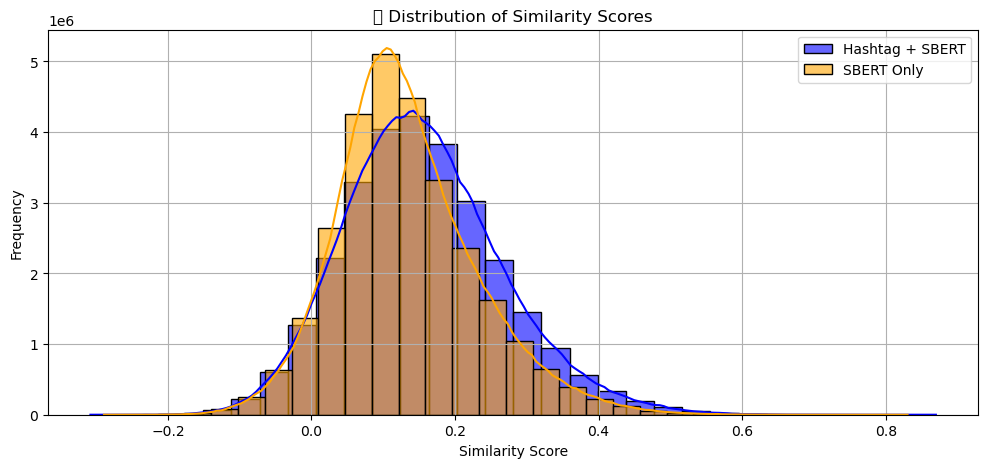

c:\ProgramData\anaconda3\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


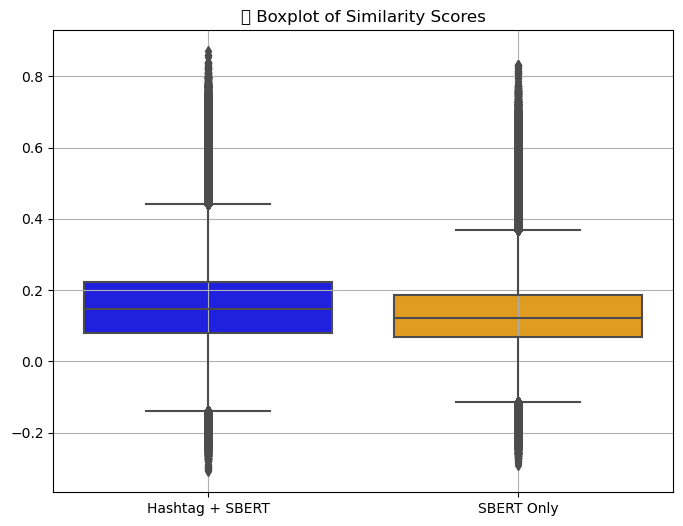

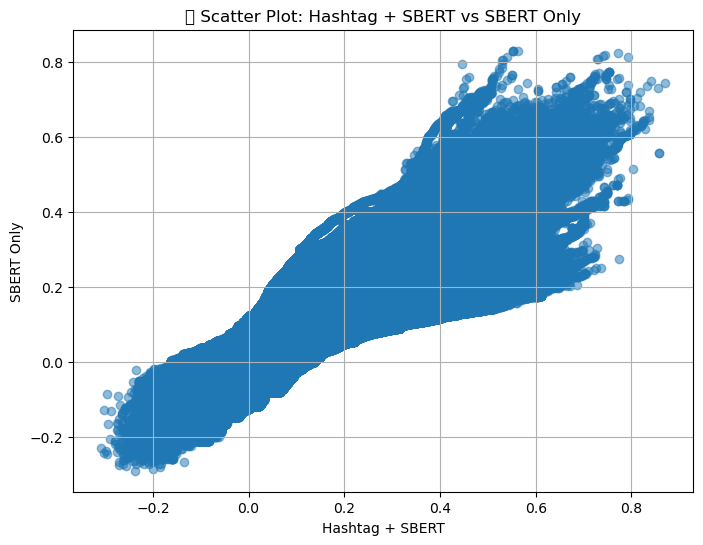

In [4]:

import matplotlib.pyplot as plt
import seaborn as sns

# ===============================
# Step 1: EDA
# ===============================
print("🔍 SBERT Only (similarity_df2) Statistics:")
print(similarity_df2['similarity_score'].describe().apply(lambda x: format(x, '.3f')))

print("\n🔍 Hashtag + SBERT (similarity_df) Statistics:")
print(similarity_df['similarity_score'].describe().apply(lambda x: format(x, '.3f')))


# ===============================
# Step 2: Histogram
# ===============================
plt.figure(figsize=(12, 5))
sns.histplot(similarity_df['similarity_score'], bins=30, kde=True, color='blue', label='Hashtag + SBERT', alpha=0.6)
sns.histplot(similarity_df2['similarity_score'], bins=30, kde=True, color='orange', label='SBERT Only', alpha=0.6)
plt.title("🔍 Distribution of Similarity Scores")
plt.xlabel("Similarity Score")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.show()

# ===============================
# Step 3: Boxplot
# ===============================
plt.figure(figsize=(8, 6))
sns.boxplot(data=[similarity_df['similarity_score'], similarity_df2['similarity_score']],
            palette=['blue', 'orange'])
plt.xticks([0, 1], ['Hashtag + SBERT', 'SBERT Only'])
plt.title("🔍 Boxplot of Similarity Scores")
plt.grid(True)
plt.show()

# ===============================
# Step 4: Scatter Plot
# ===============================
plt.figure(figsize=(8, 6))
plt.scatter(similarity_df['similarity_score'], similarity_df2['similarity_score'], alpha=0.5)
plt.title("🔍 Scatter Plot: Hashtag + SBERT vs SBERT Only")
plt.xlabel("Hashtag + SBERT")
plt.ylabel("SBERT Only")
plt.grid(True)
plt.show()



In [5]:
# ===============================
# Step 5: Correlation
# ===============================
correlation = similarity_df['similarity_score'].corr(similarity_df2['similarity_score'])
print(f"🔹 Pearson Correlation between the two methods: {correlation:.4f}")

🔹 Pearson Correlation between the two methods: 0.8465


# Matching With Other Dataset

In [ ]:
# Correct file paths
post_path_1 = 'user_product_similarity_scores2.csv'
post_path_2 = 'products from CF with predicted likes.xlsx'

# Load data
df_simscores = pd.read_csv(post_path_1)
list_sample = pd.read_excel(post_path_2)

In [ ]:
import pandas as pd

# Standardize product info
def format_product_data(row):
    category = str(row['ad_product_category']).strip() if pd.notna(row['ad_product_category']) and str(row['ad_product_category']).strip().lower() != 'na' else 'na'
    product_name = str(row['ad_product_name']).strip() if pd.notna(row['ad_product_name']) and str(row['ad_product_name']).strip().lower() != 'na' else 'na'
    brand = str(row['advertising_brand']).strip() if pd.notna(row['advertising_brand']) and str(row['advertising_brand']).strip().lower() != 'na' else 'na'

    return f"{category} {product_name} {brand}".lower().strip()  # 转换为小写并去除前后空格

# Convert product info
list_sample['product_info'] = list_sample.apply(format_product_data, axis=1)
df_simscores['product_info'] = df_simscores['product_info'].str.lower().str.strip()

# Merge
# Take user_id and product_info as index
final_df = pd.merge(list_sample, 
                    df_simscores[['user_id', 'product_info', 'similarity_score']],
                    on=['user_id', 'product_info'], 
                    how='left')

# DeDuplicate
final_df.drop_duplicates(subset=['user_id', 'product_info'], keep='first', inplace=True)

# Check for NAN 
na_count = final_df['similarity_score'].isna().sum()
print(f"❗️ Number of NaN values in 'similarity_score': {na_count}")
print(f"📊 Percentage of NaN values: {(na_count / len(final_df)) * 100:.2f}%")

# Save
final_df.to_csv('list_sample_with_similarity.csv', index=False)
print("✅ Merging, deduplication, and NaN check complete! Results saved to 'list_sample_with_similarity.csv'")


# Whatever Left Unused

In [11]:
'''
from transformers import AutoModel, AutoTokenizer
# 加载模型和 tokenizer
model_name = 'bert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

# 临时保存文件路径
TEMP_FILE = 'temp_bert_embeddings.npy'

# Function to extract BERT embeddings in batches
def get_bert_embeddings_batchwise(texts, batch_size=64):
    all_embeddings = []

    # 若存在临时文件，恢复已处理的数据
    if os.path.exists(TEMP_FILE):
        all_embeddings = list(np.load(TEMP_FILE))
        processed_count = len(all_embeddings)
        print(f"✅ Found existing progress file. Resuming from row {processed_count}...")
    else:
        processed_count = 0

    # 获取未处理的数据
    remaining_texts = texts[processed_count:]

    # 使用 tqdm 显示进度
    for i in tqdm(range(0, len(remaining_texts), batch_size), desc="Computing BERT embeddings", unit="batch"):
        batch_texts = remaining_texts[i : i + batch_size]
        inputs = tokenizer(batch_texts, padding=True, truncation=True, max_length=128, return_tensors="pt")

        with torch.no_grad():
            outputs = model(**inputs)
        
        # 获取 [CLS] token 的嵌入
        batch_embeddings = outputs.last_hidden_state[:, 0, :].numpy()

        # 追加到已处理的嵌入数据
        all_embeddings.append(batch_embeddings)

        # 每处理完一个 batch 就将结果保存
        np.save(TEMP_FILE, np.vstack(all_embeddings))

    # 最终将所有嵌入合并
    return np.vstack(all_embeddings)

# Compute embeddings in batches
embeddings = get_bert_embeddings_batchwise(captions, batch_size=64)

# 保存最终结果
np.save('final_bert_embeddings.npy', embeddings)
print("✅ BERT embeddings computed and saved successfully!")

# Remove TEMP_FILE after successful completion
if os.path.exists(TEMP_FILE):
    os.remove(TEMP_FILE)
    print(f"🗑️ TEMP_FILE '{TEMP_FILE}' deleted successfully.")
'''

✅ Found existing progress file. Resuming from row 62217...


Computing BERT embeddings: 100%|██████████| 12/12 [00:41<00:00,  3.48s/batch]


✅ BERT embeddings computed and saved successfully!


In [12]:
'''
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm
import os

# Convert embeddings list to a NumPy array
embeddings = np.array(embeddings)  # Shape: (num_posts, 768)

# 直接用 `post1` 的 `user_id` 列作为 `influencer_id`
df_captions['influencer_id'] = post1.loc[df_captions.index, 'user_id']

# 临时保存文件路径
TEMP_FILE = 'temp_influencer_embeddings.npy'

# 检查是否存在已保存的临时文件
if os.path.exists(TEMP_FILE):
    influencer_embeddings = np.load(TEMP_FILE, allow_pickle=True).item()
    print(f"✅ Found existing progress file. Resuming from {len(influencer_embeddings)} influencers processed...")
else:
    influencer_embeddings = {}  # 若无临时文件，则从头开始

# 获取未处理的 Influencer
remaining_influencers = [id for id in df_captions['influencer_id'].unique() if id not in influencer_embeddings]

# 聚合每个 Influencer 的帖子嵌入
for influencer_id in tqdm(remaining_influencers, desc="Aggregating Influencer Embeddings", unit="influencer"):
    # 获取该 Influencer 的帖子索引
    influencer_indices = df_captions[df_captions['influencer_id'] == influencer_id].index

    # 提取该 Influencer 的 Embedding
    valid_indices = [idx for idx in influencer_indices if idx < embeddings.shape[0]]  # 防止越界
    post_embeddings = embeddings[valid_indices]

    # 聚合 (Mean Pooling)
    if len(post_embeddings) > 0:  # 防止无效数据报错
        influencer_embedding = np.mean(post_embeddings, axis=0)
        influencer_embeddings[influencer_id] = influencer_embedding

    # 每处理 100 位 Influencer 保存一次
    if len(influencer_embeddings) % 100 == 0:
        np.save(TEMP_FILE, influencer_embeddings)

print("✅ Influencer embeddings aggregated successfully!")

# 转换为矩阵
influencer_ids = list(influencer_embeddings.keys())
embedding_matrix = np.vstack([influencer_embeddings[id] for id in influencer_ids])

# 计算 Influencer 之间的余弦相似度
similarity_matrix = cosine_similarity(embedding_matrix)

# 转换为 DataFrame
similarity_df = pd.DataFrame(similarity_matrix, index=influencer_ids, columns=influencer_ids)

# 保存结果
similarity_matrix_path = "influencer_similarity_matrix.xlsx"
similarity_df.to_excel(similarity_matrix_path, index=True, engine="openpyxl")

print(f"✅ Influencer similarity matrix saved successfully at: {similarity_matrix_path}")

# Remove TEMP_FILE after successful completion
if os.path.exists(TEMP_FILE):
    os.remove(TEMP_FILE)
    print(f"🗑️ TEMP_FILE '{TEMP_FILE}' deleted successfully.")

'''


✅ Found existing progress file. Resuming from 2300 influencers processed...


Aggregating Influencer Embeddings: 100%|██████████| 141/141 [00:02<00:00, 56.23influencer/s]


✅ Influencer embeddings aggregated successfully!
✅ Influencer similarity matrix saved successfully at: influencer_similarity_matrix.xlsx
